# Outlier detection workshop

We are going to investigate some methods and models to detect outliers. We'll also discuss the usecases of this methods.

Agenda: 

1. Example of biasing models quality by outliers. Robust models.
2. Mahalanobis rule
3. Local Outlier Factor
3. Isolation Forest
1. One-Class SVM

Dataset for workshop: http://odds.cs.stonybrook.edu/breast-cancer-wisconsin-original-dataset/

# Google Drive connection

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
!gdown --id 1ed2qAmyilLQeQ89fNEju5X4OssZTk91H

Downloading...
From: https://drive.google.com/uc?id=1ed2qAmyilLQeQ89fNEju5X4OssZTk91H
To: /content/breastw.csv
100% 17.5k/17.5k [00:00<00:00, 31.6MB/s]


# Necessary imports

In [3]:
import numpy as np
import pandas as pd

import itertools

from sklearn.datasets import load_wine

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

from tqdm.notebook import tqdm as tqdm

from sklearn.metrics import classification_report

from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import  train_test_split
from sklearn.metrics import r2_score

import seaborn as sns
import matplotlib.pyplot as plt

In [4]:
np.random.seed(10000)

In [5]:
def report(y_data, predictions, outlier_label =-1):
  predictions = predictions.copy()

  predictions[predictions != outlier_label] = 0
  predictions[predictions == outlier_label] = 1


  print(classification_report(y_data, predictions))

# Models bias by outliers

Some models are less robust to outliers than others. We can show that removing outliers from train data can improve metrics without changing other params.

In [ ]:
# Some code to genetare data

mean_x = 5
var_x = 4

var_y = 3

slope = 1

count_samples = 100

x = var_x * np.random.randn(count_samples) + mean_x
y = slope * x + var_y * np.random.randn(count_samples)

In [ ]:
# Some code to genetare outliers

count_outliers = 5

x_bias = 5
y_bias = 20

outliers_x = var_x * np.random.randn(count_outliers) + x_bias
outliers_y = slope * outliers_x + var_y * np.random.randn(count_outliers) + y_bias

outliers_mask = np.zeros(count_samples + count_outliers)
outliers_mask[count_samples:] = 1

data_x, data_y = np.hstack([x, outliers_x]), np.hstack([y, outliers_y])

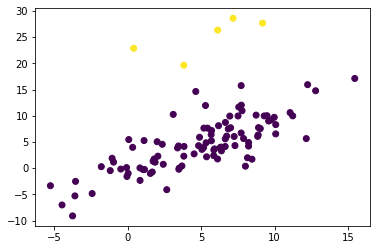

In [ ]:
plt.scatter(data_x, data_y , c=outliers_mask)

In [ ]:
x_train, x_test, y_train, y_test, train_outliers, test_outliers = train_test_split(data_x, data_y, outliers_mask, train_size=0.8)

In [ ]:
logreg = LinearRegression()

logreg.fit(x_train.reshape(-1,1), y_train)

y_pred = logreg.predict(x_test.reshape(-1,1))

r2_score(y_test, y_pred)

0.39405184193700327

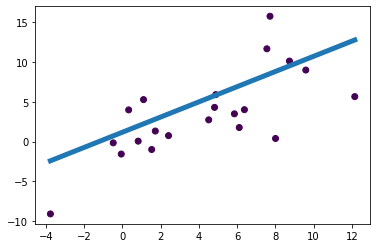

In [ ]:
plt.scatter(x_test, y_test , c=test_outliers)

plt.plot(np.sort(x_test), y_pred[np.argsort(x_test)], linewidth=5)

In [ ]:
logreg = LinearRegression()

x_train_clean = x_train[train_outliers == 0]
y_train_clean = y_train[train_outliers == 0]

logreg.fit(x_train_clean.reshape(-1,1), y_train_clean)

y_pred = logreg.predict(x_test.reshape(-1,1))

r2_score(y_test, y_pred)

0.4941204784268174

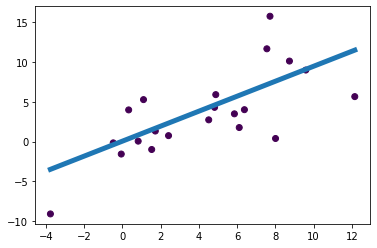

In [ ]:
plt.scatter(x_test, y_test , c=test_outliers)

plt.plot(np.sort(x_test), y_pred[np.argsort(x_test)], linewidth=5)

# Data overview

In [8]:
data = pd.read_csv('breastw.csv', index_col='Unnamed: 0')

In [10]:
data.head()

,0,1,2,3,4,5,6,7,8,target
0,5,1,1,1,2,1,3,1,1,0
1,5,4,4,5,7,10,3,2,1,0
2,3,1,1,1,2,2,3,1,1,0
3,6,8,8,1,3,4,3,7,1,0
4,4,1,1,3,2,1,3,1,1,0


In [11]:
target = 'target'

features = list(data.columns)
features.remove(target)
features

['0', '1', '2', '3', '4', '5', '6', '7', '8']

In [12]:
x_data = data[features]
y_data = data[target]


In [13]:
y_data.value_counts()

0    444
1    239
Name: target, dtype: int64

In [14]:
data[target] = data[target].astype(str)

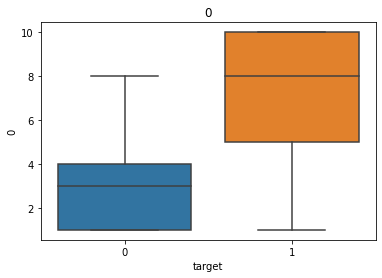

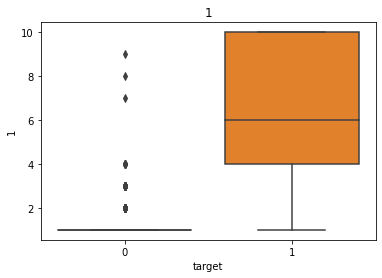

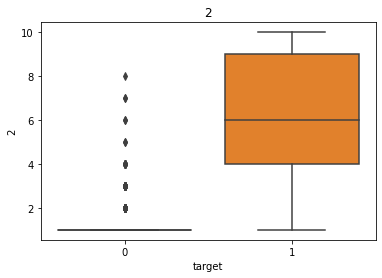

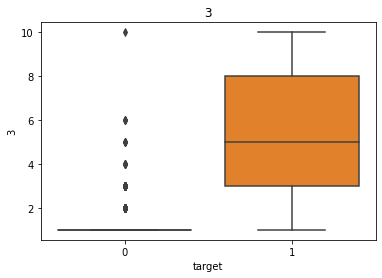

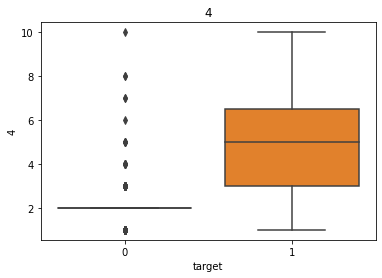

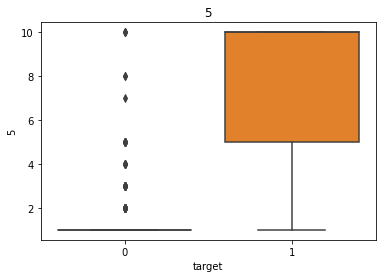

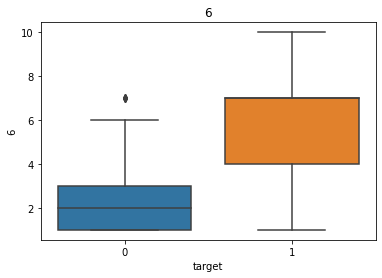

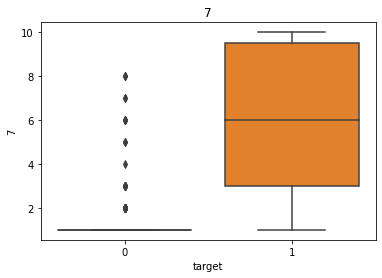

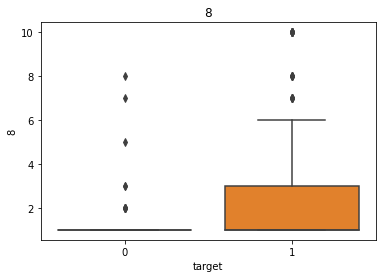

In [ ]:
for feature in features:    
    plt.figure()
    sns.boxplot(y = feature, x=target, data=data, )
    plt.title(feature)

In [15]:
dim_reducer = PCA(n_components=2)
x_reduced = dim_reducer.fit_transform(x_data)
x_reduced.shape

(683, 2)

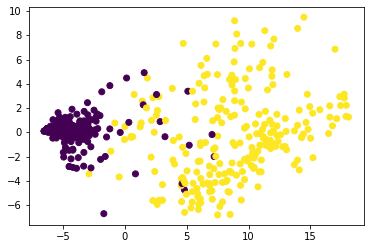

In [16]:
plt.scatter(x_reduced[:,0], x_reduced[:,1], c=y_data)

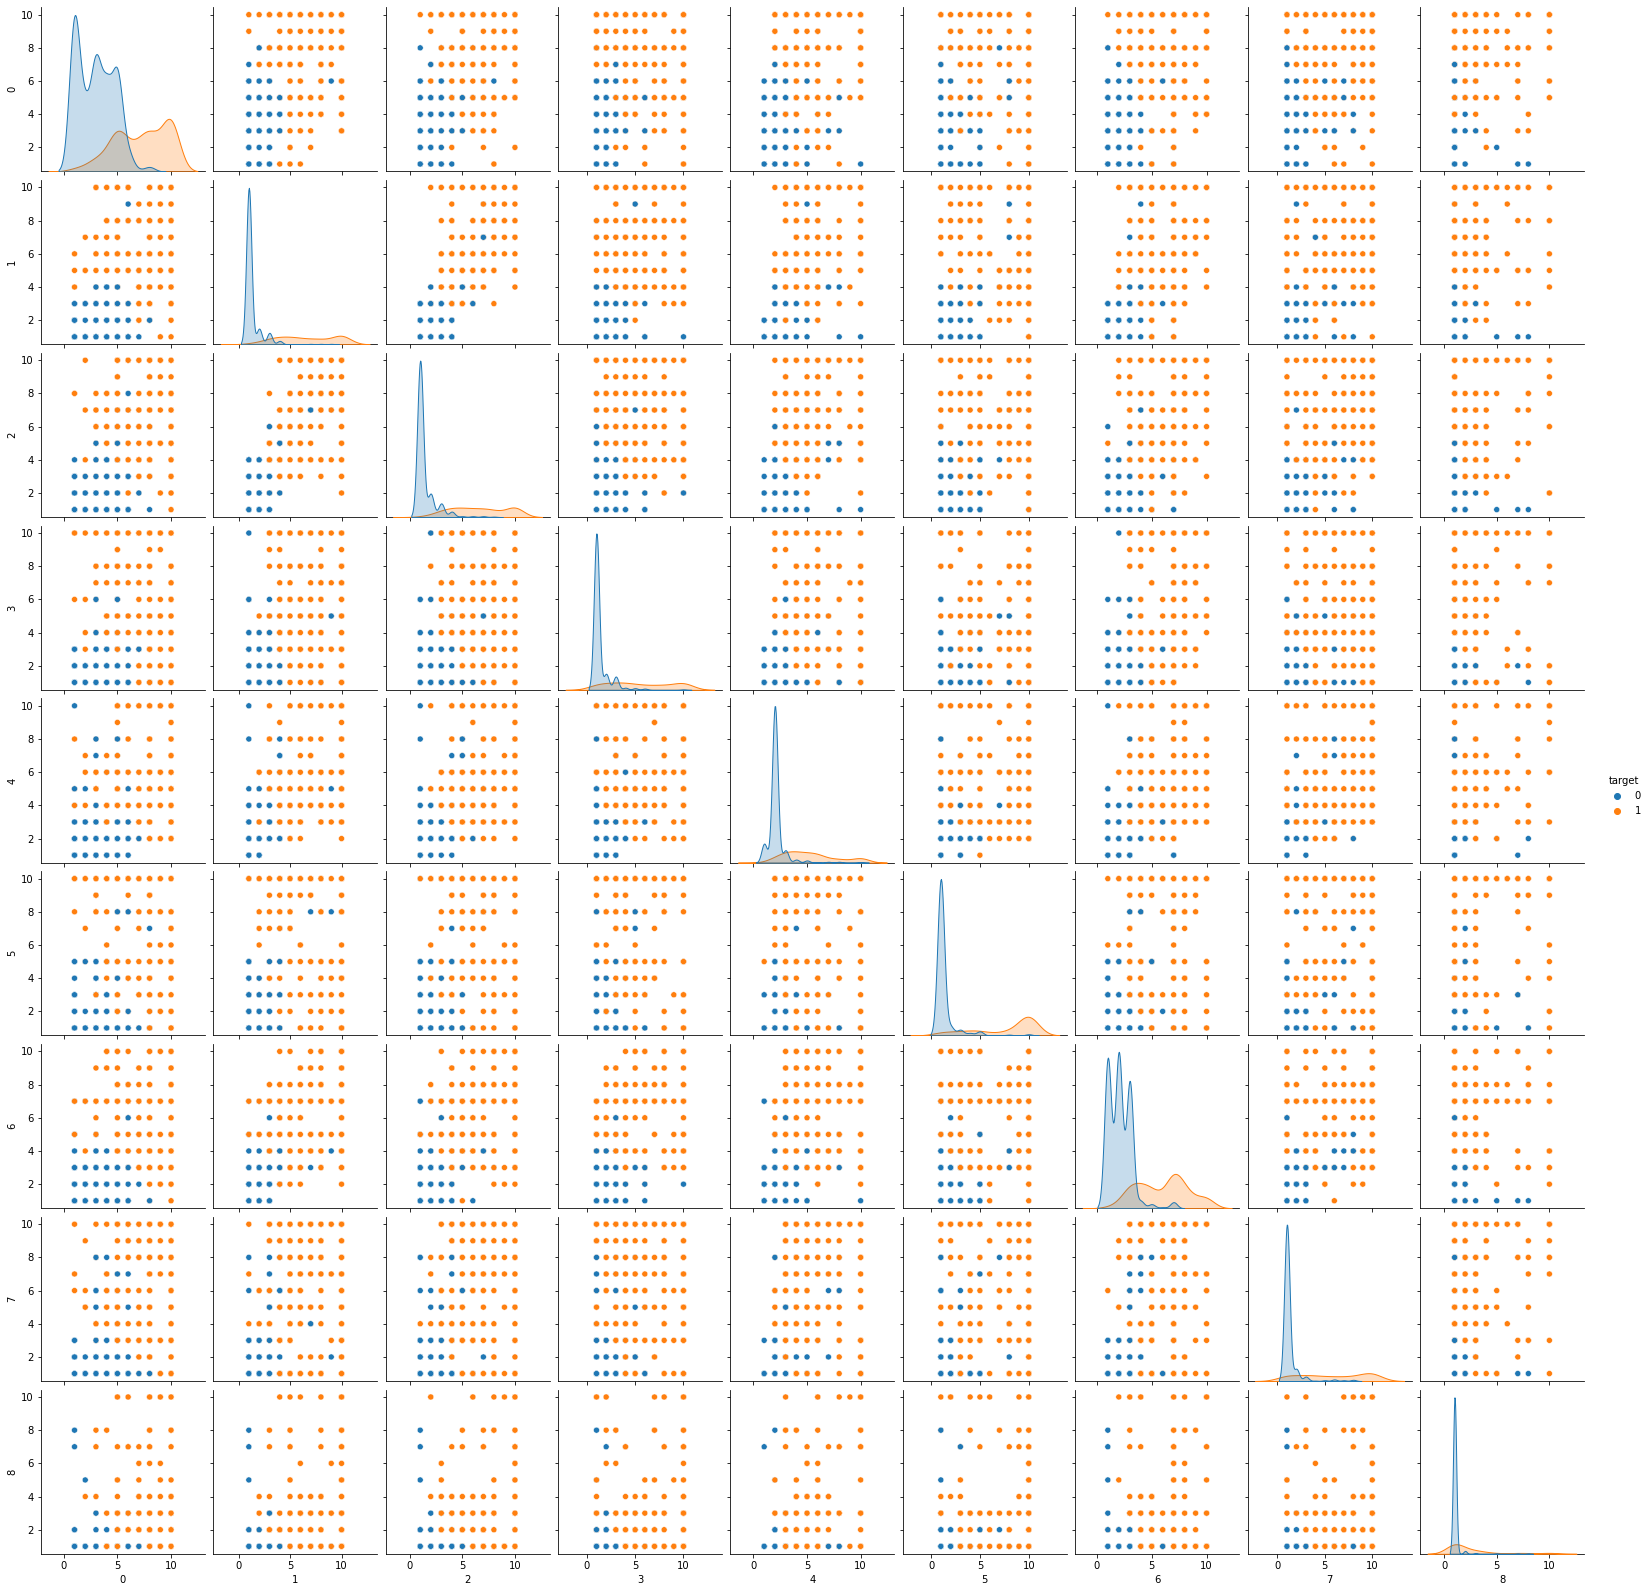

In [ ]:
sns.pairplot(data[features + [target]], hue=target)

# Mahalanobis rule

How we can measure the distance between points? One the most common metrics is euclidean distance:

> $d(x, y) = \sqrt{((x_1 - y_1)^2 + ... + (x_n - y_n)^2)}$

This metric doesn't depend on distribution of samples and equally weight all dimesions. To solve this problem we can intriduce weighted distance metric - Mahalanobis distance:
> $D_M(x,y) ^2 = (x-y)^T * C^{-1} * (x - y)$, where x, y - vectors of to measure distance and $ C^{-1}$ - inverse covariance matrix of data.

This metric rotates coordinate system to remove correlations between axes and scales to make dispersion by each axis equal to 1.

Aterward we can measure distance between samples and center of data and provide chi-square test to detect outliers:
> $\chi_n ^2 (x) = D_M(x, m)^2 = (x - m)^T * C^{-1} * (x - m)$  where m - mean vector of data, n - data dimensionality. <br>
$p\_value = 1 - \chi_{1-\alpha} ^2 (n)$





![](https://www.machinelearningplus.com/wp-content/uploads/2019/04/Mahalanobis_Distance_Usecase.jpg)


In [22]:
from scipy.spatial.distance import pdist, mahalanobis, squareform

## Compute Mahalanobis distance between random pair of rows in dataset using numpy

In [23]:
covariance_inverse = np.linalg.inv(np.cov(x_data.T))

x = x_data.iloc[0]
y = x_data.iloc[10]
left_part = np.dot(x - y, covariance_inverse)

distance = np.dot(left_part, (x - y).T)
np.sqrt(distance)

2.080485208452292

## Check yourself with scipy package
We can use scipy.spatial.distance.mahalanobis. Compare with output above. Also we can compute the full distance matrix by 'pdist' and 'squareform' functions.

In [24]:
codense = pdist(x_data, metric='mahalanobis', VI=covariance_inverse)
distance = squareform(codense)
distance[0, 10]

2.080485208452292

## Compute mean vector, distance from sample to mean and p_value.  


In [25]:
mean_vector = x_data.mean(axis=0)

bias_distance = x_data.apply(lambda row:
                             mahalanobis(mean_vector, row, VI=covariance_inverse), 
                             axis=1)

In [30]:
bias_distance.sort_values()

193    0.791821
518    0.791821
378    0.791821
633    0.791821
629    0.791821
         ...   
314    6.924810
96     6.960123
83     7.209192
161    7.825231
69     8.222439
Length: 683, dtype: float64

In [26]:
from scipy.stats import chi2

In [ ]:
1 - chi2.cdf(bias_distance.sort_values(), df=x_data.shape[1])

array([0.99978598, 0.99978598, 0.99978598, 0.99978598, 0.99978598,
       0.99978598, 0.99978598, 0.99978598, 0.99978598, 0.99978598,
       0.99978598, 0.99978598, 0.99978598, 0.99978598, 0.99978598,
       0.99978598, 0.99978598, 0.99978598, 0.99978598, 0.99978598,
       0.99963796, 0.99960447, 0.99960447, 0.99960447, 0.99960447,
       0.99960447, 0.99960447, 0.99960447, 0.99960447, 0.99958386,
       0.99955689, 0.99955689, 0.99955689, 0.99955689, 0.99955689,
       0.99955689, 0.99955689, 0.99955689, 0.99955689, 0.99955689,
       0.99950053, 0.99950053, 0.99943495, 0.99940237, 0.99940237,
       0.99940237, 0.99940237, 0.99940237, 0.99940237, 0.99940237,
       0.99940237, 0.99940237, 0.99940237, 0.99940237, 0.99940237,
       0.99937847, 0.99933978, 0.99933276, 0.99933276, 0.99933276,
       0.99931858, 0.99931858, 0.99931858, 0.99931858, 0.99931858,
       0.99930973, 0.99928447, 0.99928447, 0.99925385, 0.99921355,
       0.99920691, 0.99920691, 0.99920691, 0.99920691, 0.99920

## Visualize output predictions and get metrics

In [ ]:
predictions = np.ones(x_data.shape[0])
predictions[bias_distance > 2] = -1

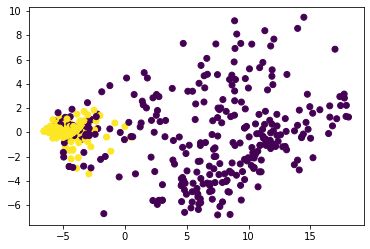

In [ ]:
plt.scatter(x_reduced[:,0], x_reduced[:,1], c=predictions)

In [ ]:
report(y_data, predictions)

              precision    recall  f1-score   support

           0       0.99      0.83      0.90       444
           1       0.75      0.98      0.85       239

    accuracy                           0.88       683
   macro avg       0.87      0.90      0.88       683
weighted avg       0.90      0.88      0.88       683



## Conclusions

1) Optimal case to use this method - multivariate gaussian distribution of data <br>
2) Straightforward usage - no hyperparams to tune <br>
3) Doesn't work in clusters case - each cluster can have its own convariance and mean. 

# Local Outlier Factor



Density based distance:

> r(x,y) - metric of distance between points. <br>
$k-distance = r(x,x_k)$ - distance between x and k nearest neighbor x_k <br>
$reachability-distance(x,y) = max\{k-distance(y), r(x,y)\}$ <br>
$lrd_k(x) = 1/(\frac{\sum_{y \in N_k(x)} reachability-distance(x,y)}{|N_k(x)|})$ - local reachability density, where $N_k(x)$ - set of k nearest neighbors. <br>
 
$LOF_k(x) = \frac{\sum_{y \in N_k(x)}(lrd(y))}{|N_k(x)|} / lrd(x)$ - fraction of mean local reachability densities of neighbros and sample's local reachability density.

If LOF_k ~ 1 => point density comparable to neighbors' => point is not outlier. <br>
If LOF >> 1 => point density strongly less than neighbors' => point is outlier

In [ ]:
from sklearn.neighbors import LocalOutlierFactor

## Try sklearn implementation sklearn.neighbors.LocalOutlierFactor



In [ ]:
lof_model = LocalOutlierFactor(n_neighbors=30,)

In [ ]:
lof_predictions = lof_model.fit_predict(x_data)

## Test other representations of data
We can pass a distance matrix computed in Mahalanabis distance section or data with reduced dimesionality

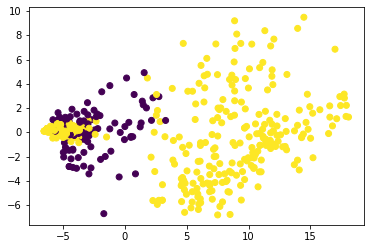

In [ ]:
plt.scatter(x_reduced[:,0], x_reduced[:,1], c=lof_predictions)

In [ ]:
report(y_data, lof_predictions, outlier_label=-1)

              precision    recall  f1-score   support

           0       0.61      0.78      0.68       444
           1       0.16      0.08      0.10       239

    accuracy                           0.53       683
   macro avg       0.38      0.43      0.39       683
weighted avg       0.45      0.53      0.48       683



## Conclusions

# Isolation Forest



Tree-based algorithm for detecting rare points. <br> Intuition: if in random decision tree point often cuts off earlier than others - it can be considered as outlier.

Algorithm of tree training:
> 1) Get random feature $p$ and split value $v$. <br>
2) Split data by feature-value pair on two subsets: $S_1$ all points with feature value less than $v$ and $S_2$ greater than $v$. <br>
3) Repeat (1)-(2) until subsets have more than 1 point.

After training a forest we intriduce measure of sample anomality as mean length of paths in all trees. <br>
If this score is less than some threshold => it is outlier
The threshold can be set manually or computed via formula in https://cs.nju.edu.cn/zhouzh/zhouzh.files/publication/icdm08b.pdf?q=isolation-forest - out of scope of this lecture.



![](https://miro.medium.com/max/700/1*xCZtQspQaHSmwniINWTeLQ.png)

In [ ]:
from sklearn.ensemble import IsolationForest

## Try sklearn.ensemble.IsolationForest

In [ ]:
iso_forest = IsolationForest()


In [ ]:
iso_predictions = iso_forest.fit_predict(x_data)

## Visualize and get metrics

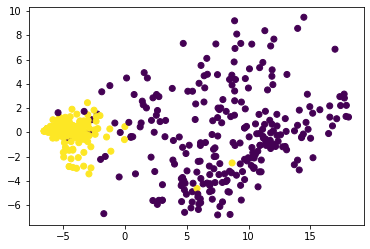

In [ ]:
plt.scatter(x_reduced[:,0], x_reduced[:,1], c=iso_predictions)

In [ ]:
report(y_data, iso_predictions, )

              precision    recall  f1-score   support

           0       0.99      0.94      0.96       444
           1       0.90      0.97      0.94       239

    accuracy                           0.95       683
   macro avg       0.94      0.96      0.95       683
weighted avg       0.96      0.95      0.95       683



# One-Class SVM

---



SVM-based model. Intuition - if we can make a decision boundary of minimal space, samples out of this boundary classidied as outliers.
<br> 
Theory similar to SVM classification, the only difference is that we don't have negative class.


![Замещающий текст](https://scikit-learn.org/stable/_images/sphx_glr_plot_oneclass_001.png)

In [ ]:
from sklearn.svm import OneClassSVM

## Try sklearn.svm.OneClassSVM

In [ ]:
y_data = y_data.astype(int)

In [ ]:
detector = OneClassSVM(
    nu=0.5,
    )

In [ ]:
svm_predictions = detector.fit_predict(distance, )

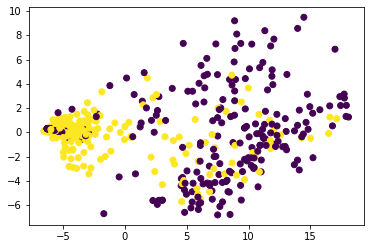

In [ ]:
plt.scatter(x_reduced[:,0], x_reduced[:,1], c=svm_predictions)

In [ ]:
report(y_data, svm_predictions, )

              precision    recall  f1-score   support

           0       0.83      0.60      0.70       444
           1       0.51      0.77      0.61       239

    accuracy                           0.66       683
   macro avg       0.67      0.69      0.66       683
weighted avg       0.72      0.66      0.67       683



## Test different representations of data
We can pass a distance matrix computed in Mahalanabis distance section or data with reduced dimesionality

In [ ]:
detector_distance = OneClassSVM(
    nu=0.5,

    )

              precision    recall  f1-score   support

           0       0.83      0.60      0.70       444
           1       0.51      0.77      0.61       239

    accuracy                           0.66       683
   macro avg       0.67      0.69      0.66       683
weighted avg       0.72      0.66      0.67       683

